In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [19]:
test_data = pd.read_csv('data/test_v2.csv')
train_data = pd.read_csv('data/train_v2.csv')

# Data Pipeline

In [23]:
%autoreload
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from include.DatetimeFromTimestamp import DatetimeFromTimestamp
from include.DataFrameDropper import DataFrameDropper
from include.DataFrameSelector import DataFrameSelector
from include.FilterNMostCommon import FilterNMostCommon


pipeline_normal = Pipeline([
    ('datetime_creator', DatetimeFromTimestamp()),
])

pipeline_1hot = Pipeline([
    ('dataframe_selector', DataFrameSelector(['product_category'])),
    ('filter_n_most_common', FilterNMostCommon(N=10, minRelFreq=0.01, attribute_name='product_category')),
    ('1hot_encoder', OneHotEncoder(sparse = False))
])

pipeline_analysis = FeatureUnion(transformer_list=[
    ('pipeline_normal', pipeline_normal),
    ('pipeline_1hot', pipeline_1hot),
])

In [24]:
train_data_treated = pipeline_analysis.fit_transform(train_data)
categories = pipeline_1hot.named_steps['1hot_encoder'].categories_
cols = list(train_data) + ['datetime'] + categories[0].tolist()

In [52]:
test_data_treated = pipeline_analysis.transform(test_data)

### Convert to DataFrame
Not necessary, we can always use the index from cols

In [45]:
train_data_treated = pd.DataFrame(train_data_treated, columns = cols)
train_data_treated.head()

,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,...,C20,C21,amount,isfraud,datetime,28905ebd,3e814130,50e219e0,Other,f028772b
0,0,1413851531856,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,-1,79,184.09,0,2014-10-21 00:32:11.856000,1,0,0,0,0
1,1,1413851817483,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,100084,79,184.09,0,2014-10-21 00:36:57.483000,1,0,0,0,0
2,2,1413852597526,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,100084,79,184.09,0,2014-10-21 00:49:57.526000,1,0,0,0,0
3,3,1413851283020,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,100084,79,184.09,0,2014-10-21 00:28:03.020000,1,0,0,0,0
4,4,1413849935779,9166c161,fe8cc448,0569f928,ecad2386,a99f214a,320,50,2161,...,-1,157,196.98,0,2014-10-21 00:05:35.779000,0,0,0,1,0


In [ ]:
test_data_treated = pd.DataFrame(test_data_treated, columns = cols[:-1])
test_data_treated.head()

# Overall analysis
* There are no null values in neither of the dataset, however, the are clearly values which are ***imputed to -1*** in the `C20` attribute as stated in Kaggle. These were probably nulls.
* 17% of the entries in the data are fraudulent.

In [56]:
test_data_treated.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32369524 entries, 0 to 32369523
Data columns (total 21 columns):
id                    32369524 non-null object
timestamp             32369524 non-null object
product_id            32369524 non-null object
product_department    32369524 non-null object
product_category      32369524 non-null object
card_id               32369524 non-null object
user_id               32369524 non-null object
C15                   32369524 non-null object
C16                   32369524 non-null object
C17                   32369524 non-null object
C18                   32369524 non-null object
C19                   32369524 non-null object
C20                   32369524 non-null object
C21                   32369524 non-null object
amount                32369524 non-null object
isfraud               32369524 non-null object
datetime              32369524 non-null object
28905ebd              32369524 non-null object
3e814130              32369524 non-null

In [54]:
train_data_treated.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32369524 entries, 0 to 32369523
Data columns (total 22 columns):
id                    32369524 non-null object
timestamp             32369524 non-null object
product_id            32369524 non-null object
product_department    32369524 non-null object
product_category      32369524 non-null object
card_id               32369524 non-null object
user_id               32369524 non-null object
C15                   32369524 non-null object
C16                   32369524 non-null object
C17                   32369524 non-null object
C18                   32369524 non-null object
C19                   32369524 non-null object
C20                   32369524 non-null object
C21                   32369524 non-null object
amount                32369524 non-null object
isfraud               32369524 non-null object
datetime              32369524 non-null object
28905ebd              32369524 non-null object
3e814130              32369524 non-null

### Value counts

In [32]:
print("Train: ")
fraud_counts = train_data['isfraud'].value_counts()
print(fraud_counts)
print(fraud_counts / train_data.shape[0])

Train: 
0    26819827
1     5549697
Name: isfraud, dtype: int64
0    0.828552
1    0.171448
Name: isfraud, dtype: float64


### Histograms

In [66]:
train_hist = train_data_treated[['C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'amount']]

[]

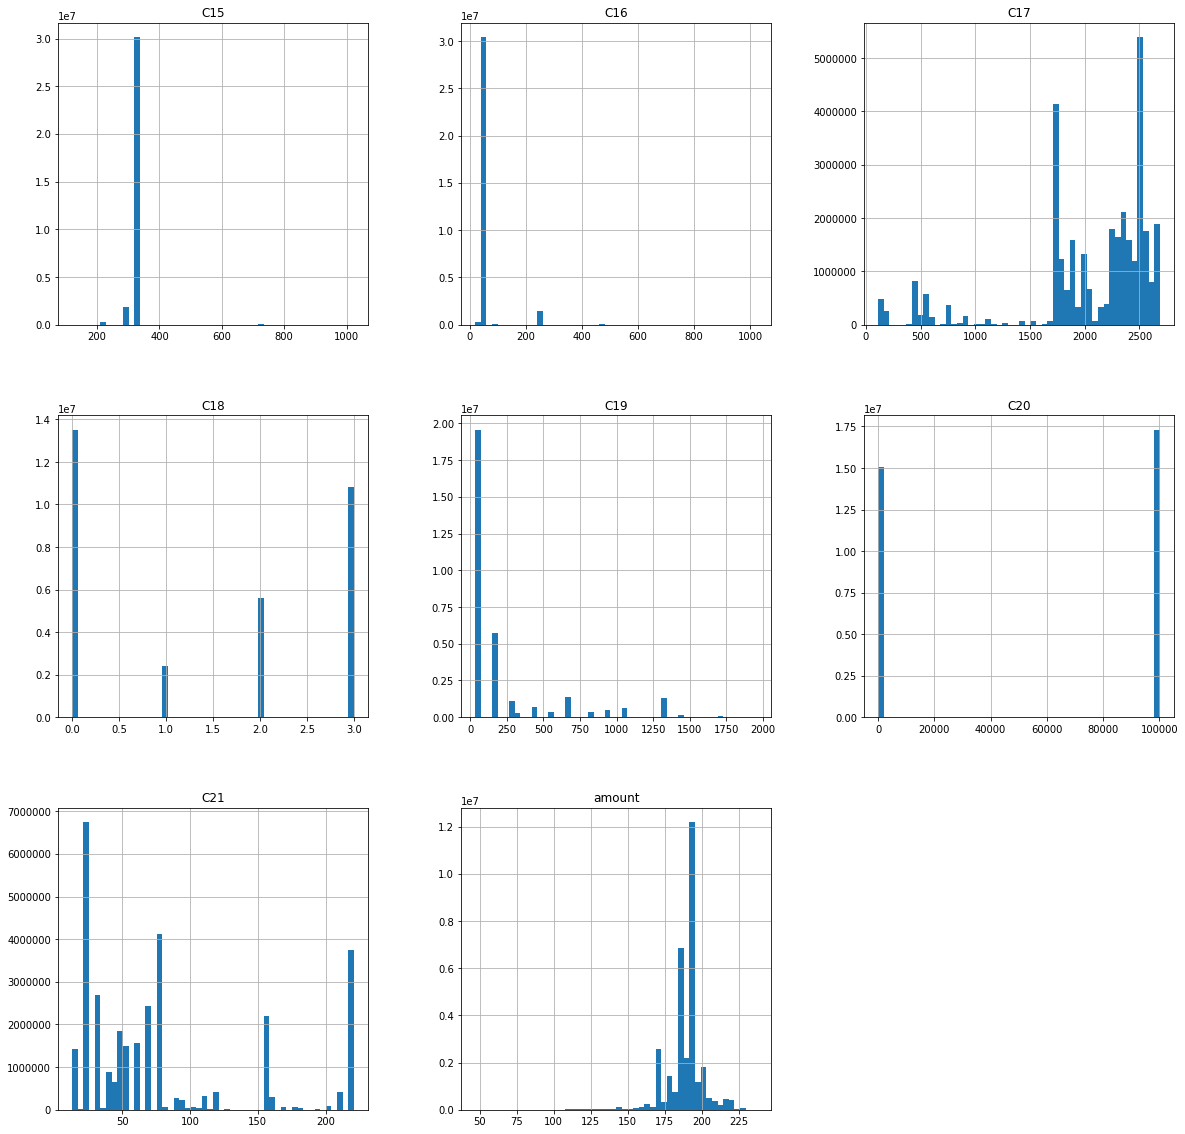

In [67]:
train_hist.hist(bins = 50, figsize=(20,20))
plt.plot()

In [63]:
train_data['C20'].value_counts()[:5]

-1         15059166
 100084     2033777
 100111     1448778
 100148     1374808
 100077     1306586
Name: C20, dtype: int64

# One by one analyzis
### timestamp/datetime
* There clearly are hours of the day with more frauds, therefore the attribute must be used

In [91]:
datetime = train_data_treated['datetime']
train_data_treated['hour_of_day'] = [dt.time().hour for dt in datetime]
train_data_treated['hour_of_day'].value_counts(sort=False)

0      658895
1      774563
2      983039
3     1049410
4     1404619
5     1605674
6     1427460
7     1472916
8     1729277
9     1894252
10    1709843
11    1670682
12    1775172
13    1944962
14    1720095
15    1646324
16    1661153
17    1693217
18    1466573
19    1058561
20     892866
21     784973
22     716090
23     628908
Name: hour_of_day, dtype: int64

In [103]:
frauds_by_hour_of_day = train_data_treated[['hour_of_day', 'isfraud']].groupby(by='hour_of_day').mean()
frauds_by_hour_of_day.index
plt.bar(frauds_by_hour_of_day.index, frauds_by_hour_of_day['isfraud'])
plt.show()

DataError: No numeric types to aggregate